In [1]:
import numpy as np
#Class for Activation Functions
class Activation:
    
    #1. Sigmoid: 1 / 1 + e^-x
    @staticmethod
    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    #2. ReLU: max(0,x)
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    #3. Hyperbolic Tangent: tanh
    @staticmethod
    def tanh(x):
        return (np.exp(x) -np.exp(-x)) / (np.exp(x) + np.exp(-x))
    
    #4. Softmax: e^x / sum(e^x)
    @staticmethod
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)


In [2]:
import numpy as np
# Class for Loss functions
class Loss:

    #Mean Absolute Error
    @staticmethod
    def mae_num(y_true, y_predicted):
        return np.mean(np.abs(y_true - y_predicted))
    
    #Mean Squared Error
    @staticmethod
    def mse_num(y_true, y_predicted):
        return np.mean((y_true - y_predicted) ** 2)
    
    #Binary Cross Entropy
    @staticmethod
    def binary_cross_entropy(y_true, y_predicted):
        epsilon = 1e-15
        #We will take max of i or epsilon so that we don't get log(i) as - infinity as log(0) is -inf
        y_pred_new = [max(i, epsilon) for i in y_predicted]
        #Then we will take min of i and 1 - epsilon so that we dont get log(1 - y_pred) as -inf
        y_pred_new = [min(i, 1 - epsilon) for i in y_pred_new]
        #Converting it into numpy array
        y_pred_new = np.array(y_pred_new)
        return -np.mean(y_true * np.log(y_pred_new) + (1 - y_true) * np.log(1 - y_pred_new))
    
    # Categorical Cross Entropy
    @staticmethod
    def cross_entropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clipping predictions for numerical stability
        if y_true.ndim == 1:  # Handling binary classification
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif y_true.ndim == 2:  # Handling multi-class classification
            return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    # Hinge Loss
    @staticmethod
    def hinge(y_true, y_pred):
        return np.mean(np.maximum(0, 1 - y_true * y_pred))

In [3]:
import numpy as np
# Class for each layer
class Layer:

    # Constructor for Layer Class
    def __init__(self, num_inputs, num_nodes, activation_func):
        # Setting the random seed to get same results
        np.random.seed(42)
        # Setting number of inputs for each layer
        self.num_inputs = num_inputs
        # Setting number of nodes for each layer
        self.num_nodes = num_nodes

        # Initializing weights and bias with random values
        self.w = np.random.uniform(-1, 1, (num_inputs, num_nodes))  #4x7
        self.b = np.random.uniform(-1, 1, num_nodes)
        
        # Setting activation function for each layer
        self.activation_func = activation_func

    #FUnciton to get the weighted sum and activation value
    def forward(self, x):
        # Calculating the weighted sum
        self.weighted_sum = np.dot(x, self.w) + self.b
        # Calculating the activation function
        self.act_node_val = self.activation_func(self.weighted_sum)
        # Returning the activated value
        return self.act_node_val
    
    #Function to get the flattened weights
    def get_weights(self):
        return self.w.flatten()
    
    #Function to get the flattened bias
    def get_bias(self):
        return self.b.flatten()
    
    #Function to update the weights and bias
    def update(self, wb_array, index):
        # Getting the number of nodes and inputs
        num_nodes = self.w.shape[1]
        num_inputs = self.w.shape[0]

        # Getting the total number of weights and bias
        total_weights =  num_nodes * num_inputs
        total_bias = num_nodes
        total = num_inputs * num_nodes + total_bias

        # Getting the new weights and bias
        cut = index + total
        new_wb = wb_array[index : cut]

        # Updating the weights and bias
        self.w = new_wb[:total_weights].reshape((num_inputs, num_nodes))
        self.b = new_wb[total_weights:]

        index += total
        return index


In [4]:
import numpy as np

#Class for a Whole new Neural Network
class NeuralNetwork:

    # Constructor for Neural Network
    def __init__(self):
        # Initializing layers as empty list
        self.layers = []
    
    # Function to add a layer to the network
    def append(self, layer):
        # Add a new layer to the network
        self.layers.append(layer)
    
    # Function for checking if the value is above threshold or not
    def threshold_function(self, output, threshold=0.5):
        # Apply a threshold to the node outputs to determine the activated nodes
        return np.where(output > threshold, 1, 0)
    
    # Function to perform forward pass for 1D data
    def forward1D(self, x_inp):  #shape is 1,4
        # Looping through each layer
        for layer in self.layers:
            # Calling the forward function
            x_inp = layer.forward(x_inp)
        # Returning the output
        return x_inp
    
    # Function to perform forward pass
    def forward(self, X):
        output = []
        # Looping through each data point
        for x_inp in iter(X):
            for layer in self.layers:
                # Calling the forward function
                x_inp = layer.forward(x_inp)
            output.append(x_inp)
        # Returning the output
        return np.array(output)
    
    def evaluate(self, x, y, loss_func):
        # Forward pass
        output = self.forward(x)

        # Checking for multi-class classification
        if len(self.layers[-1].b) > 1:
            predicted_output = np.argmax(output, axis=1)
            y_class_indices = np.argmax(y, axis=1)
            correct_output = np.sum(predicted_output == y_class_indices)
        else:
            # If single class classification then flatten the output
            output = output.flatten()
            # Apply threshold function
            predicted_output = self.threshold_function(output)
            # Calculate the number of correct outputs
            correct_output = np.sum(predicted_output == y)

        # Calculate loss
        loss = loss_func(y, output)

        # Calculate accuracy
        accuracy = correct_output / len(y)

        # Return accuracy and loss
        return accuracy, loss

    # Function to get the weights and biases
    def weightBiasList(self):
        # Initialize an empty list
        arr = np.array([])
        # Looping through each layer
        for layer in self.layers:
            # Appending the weights and biases to the list
            arr = np.append(arr, layer.get_weights())
            arr = np.append(arr, layer.get_bias())
        
        # Returning the list
        return arr.flatten()
       
    
    # Function to update the weights and biases
    def update(self, wb_array):
        # Initialize an index
        index = 0
        # Looping through each layer
        for layer in self.layers:
            # Updating the weights and biases
            index = layer.update(wb_array, index)
    


In [6]:
# Class for building the network
class ANNBuilder:

    # Function for building the network
    def build(num_nodes, activation_funcs):
        # Create a new network
        network = NeuralNetwork()
        # For loop for adding layer to the network
        for i in range(1,len(num_nodes)):
            # Add the layer to the network
            network.append(Layer(num_nodes[i-1], num_nodes[i], activation_funcs[i]))
        return network


In [7]:
import numpy as np

# Particle Class for PSO Algorithm
class Particle:
    # Constructor to initialize the particle
    def __init__(self):
        self.position = None
        self.velocity = None
        self.boundary = None
        self.pbest_position = None
        self.pbest_fitness = float('inf')
        self.fitness = 0
        self.informants = []

    # Function to set boundary
    def setBounds(self, boundary):
        self.boundary = boundary

    # Function to initialize position and velocity
    def initialize(self, weightBiasCount):
        # Setting the lower and upper bounds
        lowBound = self.boundary[0][0]
        highBound = self.boundary[0][1]
        
        # Initializing the position and velocity
        self.position = np.random.uniform(lowBound, highBound, weightBiasCount)
        self.pbest_position = self.position
        self.velocity = np.zeros(weightBiasCount)
        

    # Function to calculate velocity
    def updateVelocity(self, alpha, beta, gamma, delta, ibest_position, gbest_position):
        for i in range(len(self.velocity)):
            # Generating random numbers
            c1 = np.random.random()
            c2 = np.random.random()
            c3 = np.random.random()

            # Calculating the velocity
            cognitive = beta * c1 * (self.pbest_position[i] - self.position[i])
            social = gamma * c2 * (ibest_position[i] - self.position[i])
            global_ = delta * c3 * (gbest_position[i] - self.position[i])
            # Updating the velocity
            self.velocity[i] = alpha * self.velocity[i] + cognitive + social + global_
    
    # Function to update position
    def updatePosition(self):
        # Updating the position
        self.position = self.position + self.velocity

        # Checking if the position is within the bounds
        for i in range(len(self.position)):
            if self.position[i] < self.boundary[i][0]:
                # If not, set it to the lower bound
                self.position[i] = self.boundary[i][0]

            elif self.position[i] > self.boundary[i][1]:
                # If not, set it to the upper bound
                self.position[i] = self.boundary[i][1]
    
    # Function to set informants
    def setInformants(self,informantsList, numInformants):
        # Setting random informants
        self.informants = np.random.choice(informantsList, numInformants, replace=False)

    # Function to get the position
    def getPosition(self):
        return self.position
    
    # Function to get the fitness
    def getFitness(self):
        return self.fitness
    
    # Function to get the particle best position
    def getpBestPosition(self):
        return self.pbest_position
    
    # Function to get the particle best fitness
    def getpBestFitness(self):
        return self.pbest_fitness

    # Function to print the particle information
    def print(self):
        print("=====================================================")
        print("=           Particle Information                    =")
        print("=====================================================")
        print("Position        : ", self.position)
        print("Velocity        : ", self.velocity)
        print("Best Position   : ", self.pbest_position)
        print("Fitness         : ", self.fitness)
        print("Best Fitness    : ", self.pbest_fitness)
        print("Informants      : ", self.informants)
        print("=====================================================")
        return
    


In [13]:
import numpy as np
# Class for PSO Algorithm
class PSO:
    # Constructor
    def __init__(self, population, boundary, network, numInformants):
        self.population = population
        self.particles = [Particle() for i in range(population)]
        self.boundary = boundary
        self.network = network
        self.numInformants = numInformants
        self.gbest_fitness = float('inf')
        self.gbest_position = None
        self.gbest_accuracy = 0
    
    # Function to print the parameters
    def print(self):
        print("=====================================")
        print("PSO Parameters")
        print("=====================================")
        print("Population: ", self.population)
        print("Boundary: ", self.boundary)
        print("Number of Informants: ", self.numInformants)
        print("=====================================")
    

    # Function to initialize the population
    def initialize(self):
        # Getting the number of weights and biases
        weightBiasCount = self.network.weightBiasList().shape[0]
        # Looping through each particle
        for particle in self.particles:

            # Setting the boundary
            x = [[self.boundary[0], self.boundary[1]] for j in range(weightBiasCount)]
            particle.setBounds(x) 
            
            # Initializing the particle
            particle.initialize(weightBiasCount)

            # Set the informants
            informantsList = [j for j in self.particles if j != self.particles.index(particle)]
            particle.setInformants(informantsList, self.numInformants)
    
    # Function to train the network
    def train(self, x_train, y_train, loss_func, epochs, alpha, beta, gamma, delta):
        
        # Initializing the population
        self.initialize()
        epoch_loss = []
        epoch_acc = []
        # Looping through each epoch
        for epoch in range(epochs):

            # Looping through each particle
            for particle in self.particles:

                # Updating the network with the particle position
                self.network.update(particle.position)

                # Calculating the fitness
                accuracy, fitness = self.network.evaluate(x_train, y_train, loss_func)
                particle.fitness = fitness

                # Checking if the fitness is better than the best fitness
                if fitness < particle.pbest_fitness:
                    # Setting the best fitness
                    particle.pbest_fitness = fitness
                    # Setting the best position
                    particle.pbest_position = particle.position

                # Checking if the fitness is better than the global best fitness
                if fitness < self.gbest_fitness:
                    # Setting the global best fitness
                    self.gbest_fitness = fitness
                    # Setting the global best position
                    self.gbest_position = particle.position
                    self.gbest_accuracy = accuracy

                # Updating the velocity
                particle.updateVelocity(alpha, beta, gamma, delta, particle.informants[0].getpBestPosition(), self.gbest_position)

                # Updating the position
                particle.updatePosition()

                informantsList = [j for j in self.particles if j != particle]
                particle.setInformants(informantsList, self.numInformants)
            epoch_loss.append(round(self.gbest_fitness, 4))
            epoch_acc.append(round(self.gbest_accuracy * 100, 2))
            print("Epoch: ", epoch, '/', epochs,'============================================>',end = '')
            print(" Loss: ", round(self.gbest_fitness, 4), " Accuracy: ", round(self.gbest_accuracy * 100, 2))
            # Updating the network with the global best position
            self.network.update(self.gbest_position)
        # Returning the global best fitness and position
        return fitness, accuracy, epoch_loss, epoch_acc,




In [15]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('../Dataset/data_banknote_authentication.csv', header=None)

# Shuffle the dataset to get diverse training and testing sets
df = df.sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)


#one hot encoding for multi-class classification
def one_hot_encode(y, unique_classes):
    one_hot_vals = np.zeros((y.shape[0], len(unique_classes)))
    for i, cls in enumerate(unique_classes):
        one_hot_vals[y == cls, i] = 1
    return one_hot_vals

# Split the dataset into training and testing here
df_train = df.iloc[:1000]
df_test = df.iloc[1000:]

# check if data is multi-class or binary
isMultiClass = len(df_train.iloc[:, -1].unique()) > 2

# Split the dataset into training and testing here
if isMultiClass:
    unique_classes = df_train.iloc[:, -1].unique()
    #use one hot encoding for multi-class classification for the labels
    X_train = df_train.iloc[:, :-1].values
    y_train = one_hot_encode(df_train.iloc[:, -1].values, unique_classes)
    
    X_test = df_test.iloc[:, :-1].values
    y_test = one_hot_encode(df_test.iloc[:, -1].values, unique_classes)

else:
    #no one hot encoding for binary classification
    X_train = df_train.iloc[:, :-1].values
    y_train = df_train.iloc[:, -1].values
    
    X_test = df_test.iloc[:, :-1].values
    y_test = df_test.iloc[:, -1].values

# set output layer nodes based on binary or multi-class classification
# for binary classification we will have 1 output node
# for multi-class classification we will have number of output nodes equal to number of classes

if isMultiClass:
    num_classes = len(df_train.iloc[:, -1].unique())
else:
    num_classes = 1

# Set input layer nodes equal to number of features in the dataset
num_cols = X_train.shape[1]

# Set the number of nodes in each layer
num_nodes = [num_cols, 7, 4, num_classes]

# Multi-class classification :
#       use softmax activation function for output layer
#       use cross entropy loss function
# Binary classification :
#       use sigmoid activation function for output layer
#       use binary cross entropy loss function
if num_classes > 2:
    activation_funcs = [Activation.sigmoid, Activation.sigmoid, Activation.sigmoid, Activation.softmax]
    lossfunction = Loss.cross_entropy
else:
    activation_funcs = [Activation.sigmoid, Activation.sigmoid, Activation.sigmoid,Activation.sigmoid]
    lossfunction = Loss.binary_cross_entropy

# Build the network
network = ANNBuilder.build(num_nodes, activation_funcs)

#Shape of the network
print("=====================================")
print("Shape of the network")
print("=====================================")
for i in range(len(network.layers)):
    print("Layer ", i+1, ": ", network.layers[i].w.shape)
print("=====================================")

# Build the PSO object
pso = PSO(20, (-1,1), network, 3)

# Train the network
fitness, accuracy, epoch_loss, epoch_acc = pso.train(X_train, y_train, lossfunction , 500, 0.5, 1.4, 1.4, 1.2)

# Evaluate on train set
print("performance on train set")
accuracy, loss = network.evaluate(X_train, y_train, lossfunction)

print("Train Accuracy: ", round(accuracy*100, 4), "%")
print("Train Loss: ", loss)

print("performance on test set")
accuracy, loss = network.evaluate(X_test, y_test, lossfunction)
print("Test Accuracy: ", round(accuracy*100, 4), "%")
print("Test Loss: ", loss)

Shape of the network
Layer  1 :  (4, 7)
Layer  2 :  (7, 4)
Layer  3 :  (4, 1)
Epoch:  0 / 500 ============================================> Loss:  0.6783  Accuracy:  56.7
Epoch:  1 / 500 ============================================> Loss:  0.6539  Accuracy:  75.7
Epoch:  2 / 500 ============================================> Loss:  0.6447  Accuracy:  66.4
Epoch:  3 / 500 ============================================> Loss:  0.6088  Accuracy:  56.7
Epoch:  4 / 500 ============================================> Loss:  0.6088  Accuracy:  56.7
Epoch:  5 / 500 ============================================> Loss:  0.5705  Accuracy:  56.7
Epoch:  6 / 500 ============================================> Loss:  0.5577  Accuracy:  76.4
Epoch:  7 / 500 ============================================> Loss:  0.5487  Accuracy:  77.2
Epoch:  8 / 500 ============================================> Loss:  0.5469  Accuracy:  88.1
Epoch:  9 / 500 ============================================> Loss:  0.5242  Accuracy

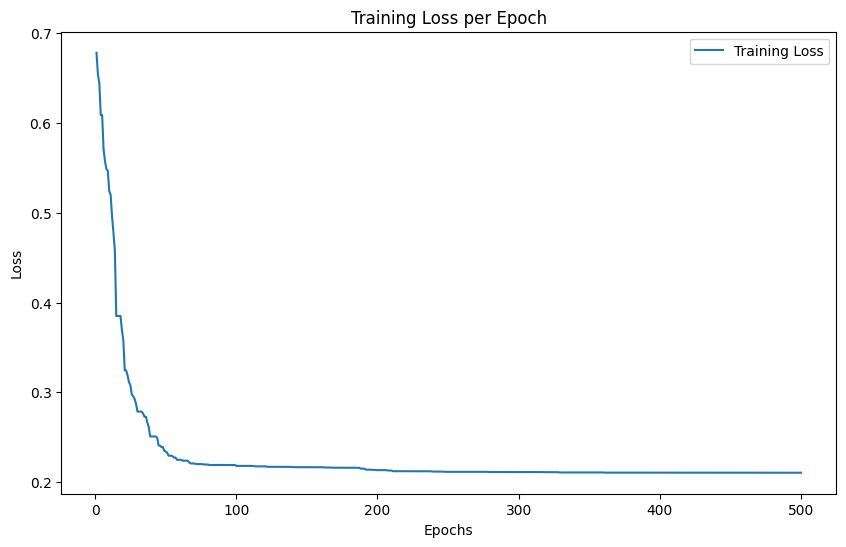

In [17]:
import matplotlib.pyplot as plt
epochs = 500
# Create a range of epochs (from 1 to num_epochs)
num_epochs = range(1, epochs + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, epoch_loss, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

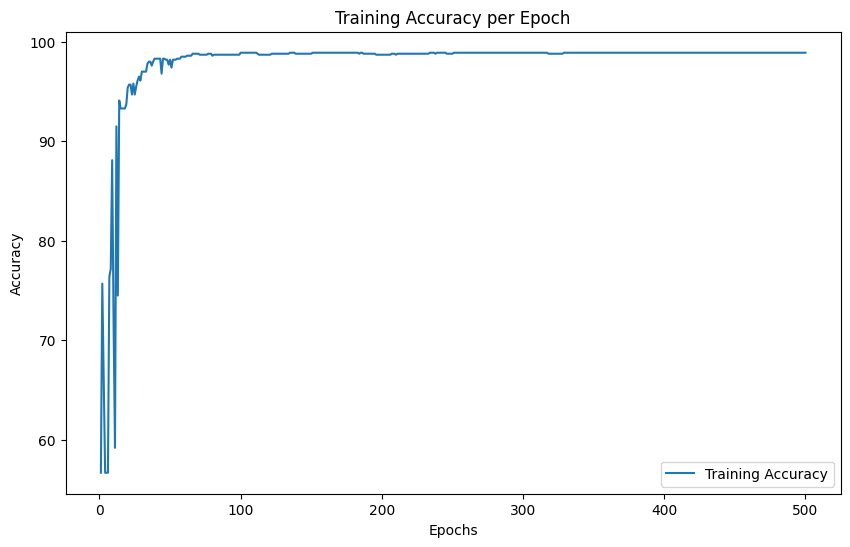

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, epoch_acc, label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

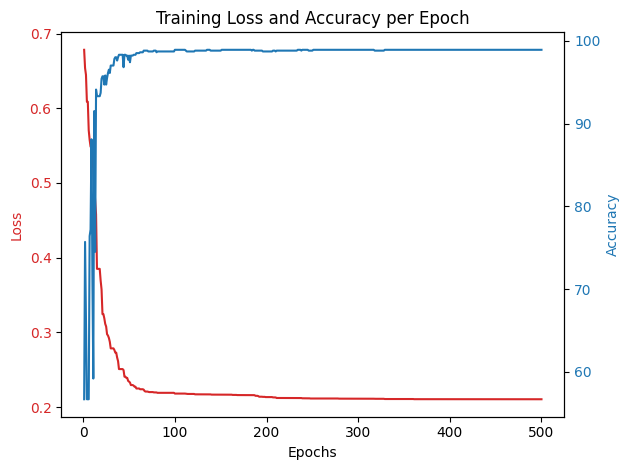

In [19]:
# Create a new figure and a primary y-axis
fig, ax1 = plt.subplots()

# Plot the loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(num_epochs, epoch_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the accuracy on the secondary y-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(num_epochs, epoch_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot with a title
plt.title('Training Loss and Accuracy per Epoch')
fig.tight_layout()  # To ensure the labels do not get cut off
plt.show()

In [ ]:
predictions = output # Replace with your actual predictions
true_values = trainY  # Replace with your actual labels
errors = np.array(predictions) - np.array(true_values)

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()